# Clothes Recommendation System (DenseNet121)

Bulding Clothes Recommendation System using DenseNet121

Importing libraries

In [3]:
import numpy as np
import pandas as pd
import os 
import tensorflow.keras as keras
from keras import Model
from keras.applications.densenet import DenseNet201, DenseNet121
from keras.preprocessing import image
from keras.applications.densenet import preprocess_input, decode_predictions
from keras.layers import GlobalMaxPooling2D
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import pathlib
from sklearn.metrics.pairwise import linear_kernel
import warnings
warnings.filterwarnings("ignore")

In [4]:
path ='C:/Users/tswar/Documents/PERSONAL PROJECTS/ImData'
dataset_path = pathlib.Path(path)
images=os.listdir(dataset_path)
images

['.ipynb_checkpoints',
 'clothes-recommendation-system-using-densenet121.ipynb',
 'images',
 'images.csv',
 'Image_Recommendation_system.pdf',
 'styles',
 'styles.csv']

Showing 10 images in dataset

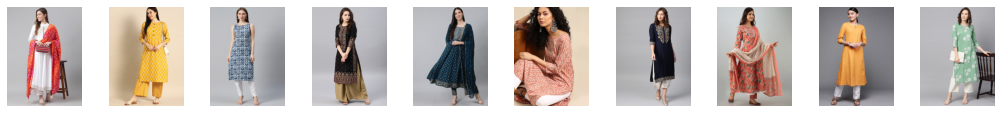

In [5]:
plt.figure(figsize=(20,20))
for i in range(10, 20):
    plt.subplot(6, 10, i-10+1)
    cloth_img =  mpimg.imread(path +'/images/'+ str(i) +'.jpg')
    plt.imshow(cloth_img)
    plt.axis("off")
plt.subplots_adjust(wspace=-0.5, hspace=1)
plt.show()

DataFrame with categories and adding column of image names

In [6]:
df = pd.read_csv(path + "/styles.csv", nrows=6000, error_bad_lines=False)
df['image'] = df.apply(lambda x: str(x['id']) + ".jpg", axis=1)
df = df.reset_index(drop=True)
print(df.shape)
df.head(5)

(2537, 6)


,id,Brand,Description,Rating,Price,image
0,0,Khushal K,Women Black Ethnic Motifs Printed Kurta with P...,4.4,Rs. 1529,0.jpg
1,1,KALINI,Women Teal Yoke Design Kurta with Palazzos & W...,4.5,Rs. 887,1.jpg
2,2,ZIYAA,Floral Leafy Foil Print Kurta Set,3.5,Rs. 641,2.jpg
3,3,AHIKA,Women Black & Green Printed Straight Kurta,4.0,Rs. 526,3.jpg
4,4,Anouk,Women Pink Embroidered Kurta with Palazzos,4.4,Rs. 1049,4.jpg


Setting the Pre-Trained model DenseNet121

In [7]:
#image dim
img_width, img_height, chnl = 200, 200, 3

# DenseNet121
densenet = DenseNet121(include_top=False, weights='imagenet', input_shape=(img_width, img_height, chnl))
densenet.trainable = True

# Add Layer Embedding
model = keras.Sequential([
    densenet,
    GlobalMaxPooling2D()
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 6, 6, 1024)        7037504   
                                                                 
 global_max_pooling2d (Globa  (None, 1024)             0         
 lMaxPooling2D)                                                  
                                                                 
Total params: 7,037,504
Trainable params: 6,953,856
Non-trainable params: 83,648
_________________________________________________________________


Function of model prediction

In [8]:
def img_path(img):
    return path + '/images/' + img
def model_predict(model, img_name):
    # Reshape
    img = image.load_img(img_path(img_name), target_size=(img_width, img_height))
    # img to Array
    x   = image.img_to_array(img)
    # Expand Dim (1, w, h)
    x   = np.expand_dims(x, axis=0)
    # Pre process Input
    x   = preprocess_input(x)
    return model.predict(x).reshape(-1)

Building data frame of model prediction for all our images from dataset (getting embedding for all items in dataset)

In [9]:
df_copy      = df
df_embedding = df_copy['image'].apply(lambda x: model_predict(model, x))
df_embedding = df_embedding.apply(pd.Series)
df_embedding.head(5)

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0.002656,0.015560,0.015131,0.010902,0.589306,4.154886,0.001717,0.018514,1.823854,0.001918,...,0.540762,0.886532,7.656699,0.334913,3.271178,2.003217,1.232616,4.362402,1.509823,6.724207
1,0.002656,0.015560,0.015131,0.010902,0.589306,4.154886,0.001717,0.018514,1.823854,0.001918,...,0.540762,0.886532,7.656699,0.334913,3.271178,2.003217,1.232616,4.362402,1.509823,6.724207
2,0.001355,0.010881,0.016512,0.015491,0.283380,1.329364,0.001426,0.016255,0.711587,0.002493,...,1.753232,0.047669,6.471742,2.673195,0.225519,1.781015,0.427489,4.629658,3.026769,4.430348
3,0.002154,0.020783,0.017139,0.007893,0.457105,5.579158,0.001452,0.019316,1.146074,0.002996,...,1.171279,0.839257,5.784052,2.424511,2.282531,3.333949,0.929800,9.150223,1.490798,2.656369
4,0.001122,0.007291,0.008461,0.011833,0.335641,3.598948,0.001603,0.016844,0.747172,0.002555,...,1.150610,0.446434,1.886934,1.865528,1.351579,2.091583,2.705380,15.452310,0.970784,5.599457


Computing a cosine similarity to calculate a numeric quantity that denotes the similarity between two images. It is relatively easy and fast to calculate.

In [10]:
cosine_sim = linear_kernel(df_embedding, df_embedding)

Getting indices

In [11]:
indices = pd.Series(range(len(df)), index=df.index)

Getting recommendations using the cosine similarity

In [12]:
def get_recommendations(index, df, cosine_sim=cosine_sim):
    idx = indices[index]
    print("This is IDX",idx)

    # Get the pairwsie similarity scores of all clothes with that one
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the clothes based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 5 most similar clothes
    sim_scores = sim_scores[1:6]

    # Get the clothes indices
    cloth_indices = [i[0] for i in sim_scores]

    # Return the top 10 most clothes
    return df['image'].iloc[cloth_indices]

Checking the result 

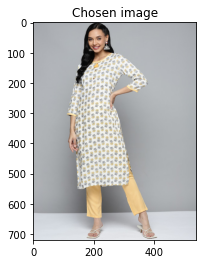

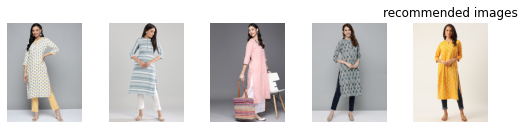

In [18]:
chosen_img_indx = 369

recommendation = get_recommendations(chosen_img_indx, df, cosine_sim)
recommendation_list = recommendation.to_list()
#chosen image
chosen_img =  mpimg.imread(path + '/images/' + df.iloc[chosen_img_indx].image)
plt.title("Chosen image")
plt.imshow(chosen_img)
#recommended images
plt.figure(figsize=(20,20))
j=0
for i in recommendation_list:
    plt.subplot(6, 10, j+1)
    cloth_img =  mpimg.imread(path + '/images/'+ i)
    plt.imshow(cloth_img)
    plt.axis("off")
    j+=1
plt.title("recommended images")
plt.subplots_adjust(wspace=-0.5, hspace=1)
plt.show()

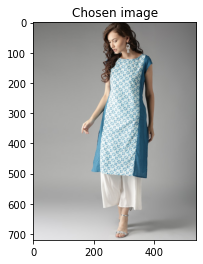

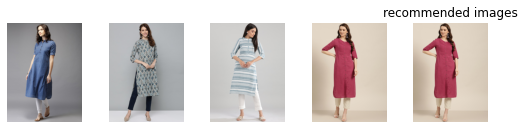

In [14]:
chosen_img_indx = 259

recommendation = get_recommendations(chosen_img_indx, df, cosine_sim)
recommendation_list = recommendation.to_list()
#chosen image
chosen_img =  mpimg.imread(path + '/images/' + df.iloc[chosen_img_indx].image)
plt.title("Chosen image")
plt.imshow(chosen_img)
#recommended images
plt.figure(figsize=(20,20))
j=0
for i in recommendation_list:
    plt.subplot(6, 10, j+1)
    cloth_img =  mpimg.imread(path + '/images/'+ i)
    plt.imshow(cloth_img)
    plt.axis("off")
    j+=1
plt.title("recommended images")
plt.subplots_adjust(wspace=-0.5, hspace=1)
plt.show()